## Lab 2: Web Scraping

Hanna Svenson

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'} 
url = 'https://washingtondc.craigslist.org/search/jwa?purveyor=owner#search=1~gallery~0~0' 
raw = requests.get(url,headers=header) # Get page

### 1. Pick something else on Craigslist: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of EDA you'd do with it.

We are looking at jewelry sold in DC (there were more listings there than Charlottesville). 

In [2]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings

### 2. Get your search results of interest and extract data from them

In [3]:
import re # Regular expressions

jewelry_types = ['watch', 'earrings', 'necklace', 'bracelet', 'ring', 'pin', 'pendant', 'chain']

data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get brand from the title string:
    words = title.split()
    hits = [word for word in words if word in jewelry_types] # Find brands in the title
    if len(hits) == 0:
        jwltype = 'other'
    else:
        jwltype = hits[0]
    # Get years from title string:
    regex_search = re.search('men', title ) # if "men" is found in title, classify it as a men's item
    if regex_search is None: # If no hits, not a mens item
        men = False 
    else: 
        men = True
    #
    data.append({'title':title,'price':price,'type':jwltype,'men\'s item':men,'link':link})


With the data scraped from Craigslist, we can put it in a dataframe and wrangle it. Of course, price and year come in as text, not numbers, and need to be typecast/coerced:

In [4]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
print(df.shape)
df.to_csv('craigslist_dc_jewelry.csv') # Save data in case of a disaster
df.head()

(353, 5)


C:\Users\jda6qt\AppData\Local\Temp\ipykernel_27472\2536136190.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['price'] = df['price'].str.replace('$','')


,title,price,type,men's item,link
0,huge blue lapis lazuli and turquoise statement...,150,ring,True,https://washingtondc.craigslist.org/doc/jwl/d/...
1,diamond tiara,15,other,False,https://washingtondc.craigslist.org/doc/jwl/d/...
2,men’s swiss watch,460,watch,True,https://washingtondc.craigslist.org/mld/jwl/d/...
3,new men's watch,450,watch,True,https://washingtondc.craigslist.org/mld/jwl/d/...
4,"cubic zirconia wedding ring set, size 10",10,ring,False,https://washingtondc.craigslist.org/doc/jwl/d/...


### 3. Wrangle your data, do some EDA, and make some plots. Try to find some interesting relationships or stories to tell about your data.

count    3.530000e+02
mean     4.104748e+03
std      6.576569e+04
min      0.000000e+00
25%      1.200000e+01
50%      5.000000e+01
75%      3.600000e+02
max      1.234567e+06
Name: price, dtype: float64


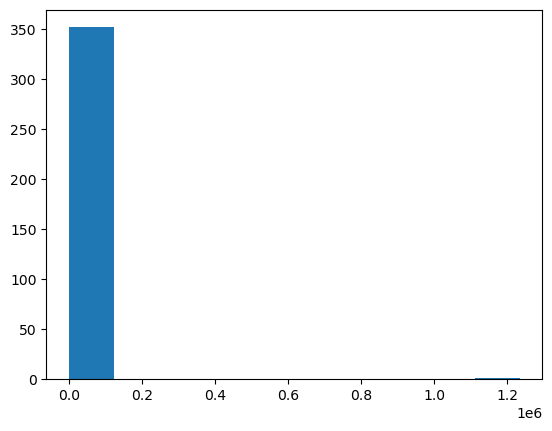

count       353
unique        9
top       other
freq        114
Name: type, dtype: object


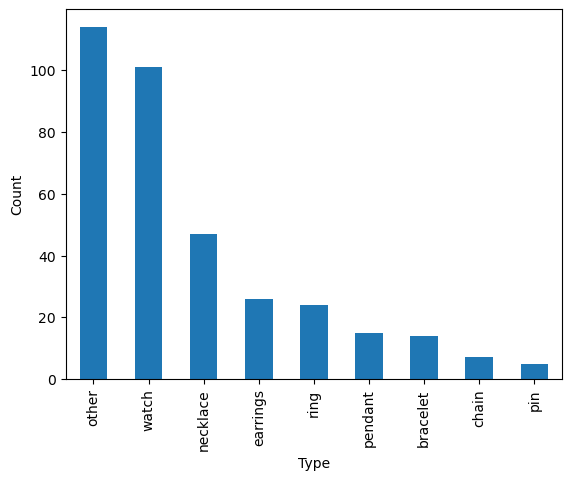

In [5]:
# EDA for price and type:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
print(df['type'].describe())
df['type'].value_counts().plot(kind='bar', xlabel='Type', ylabel='Count')
plt.show()

count     350.000000
mean      364.028571
std      1045.146284
min         0.000000
25%        12.000000
50%        50.000000
75%       360.000000
max      9500.000000
Name: price, dtype: float64


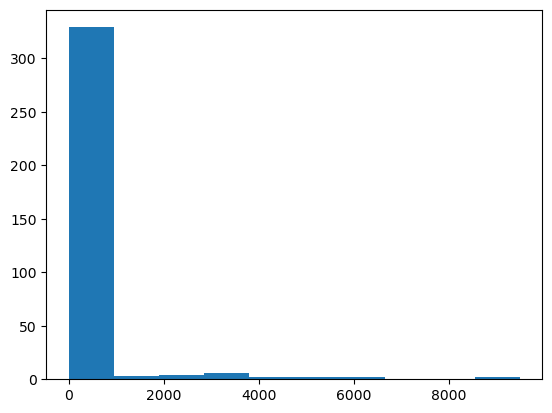

In [6]:
#I only wan't to look at items less than $10,000
df = df[df['price'] <= 10000]

print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()

In [7]:
# Price by type:
df.loc[:,['price','type']].groupby('type').describe()

price                                                              
          count        mean          std   min     25%    50%     75%     max
type                                                                         
bracelet   14.0  133.785714   210.425276   6.0   25.00   45.0  148.75   800.0
chain       7.0   34.285714    48.941170  10.0   10.00   10.0   30.00   140.0
earrings   26.0  163.730769   591.981389   0.0    9.25   15.0   21.50  3000.0
necklace   47.0  176.234043   606.621478   0.0   10.00   15.0   57.50  3000.0
other     112.0  529.169643  1600.130135   0.0   10.00   20.0  155.00  9500.0
pendant    15.0   31.266667    48.702400  10.0   10.00   10.0   29.50   200.0
pin         5.0   25.400000    16.742162   1.0   20.00   25.0   36.00    45.0
ring       23.0  744.000000  1195.201809   8.0  100.00  300.0  750.00  5000.0
watch     101.0  354.277228   514.336565  10.0   75.00  360.0  360.00  4000.0

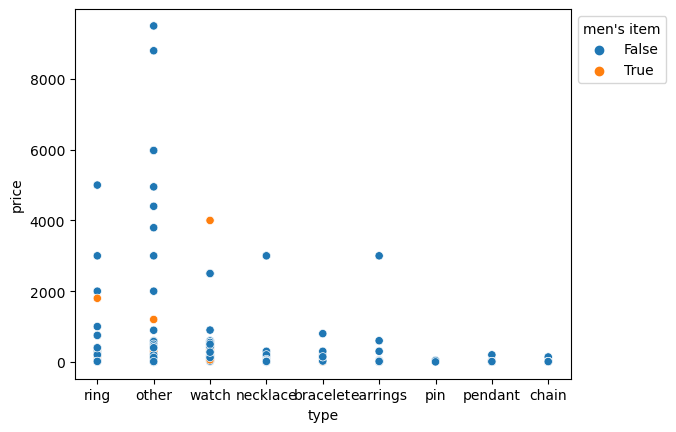

In [8]:
ax = sns.scatterplot(data=df, x='type', y='price',hue='men\'s item')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))